# **Fake Reviews - Explainable AI (XAI)**
---

**Notes:**
- You need to store the TF-IDF matrix (or the matrix from SelectKBest) & list of random walks to be able to retrieve the original nodes
- `X_new` refers to the matrix generated by SelectKBest feature selection & `str_walks` to the list of random walks
- We have provided with sample files to test out the XAI

### **Import Libraries**

In [14]:
import pandas as pd
import numpy as np
import pickle
import warnings
warnings.filterwarnings('ignore')

import lime
import lime.lime_tabular

import shap

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

### **Load the Dataset**

In [15]:
df = pd.read_csv('deceptive-cleaned.csv')
node_embeddings = pd.read_pickle('node_embeddings.pkl')
X_new = pd.read_pickle('X_new.pkl')

with open('str_walks.pkl', "rb") as f:
    str_walks = pickle.load(f)

X = node_embeddings.drop(['class'], axis=1)
y = node_embeddings['class']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7, stratify=y)

base_model = SVC(C=100, degree=2, gamma=0.03, kernel='poly', probability=True)
model = base_model.fit(X_train, y_train)
predict = model.predict(X_test)

### **LIME**

In [17]:
#deceptive = 0
#truthful = 1

true_labels = {0: 'deceptive', 1: 'truthful'}

explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values,
                                                   feature_names=X_train.columns.values.tolist(),
                                                   class_names=['deceptive', 'truthful'],
                                                   discretize_continuous=False,
                                                   mode='classification')

i = np.random.randint(0, X_test.shape[0])
exp = explainer.explain_instance(X_test.values[i],
                                 model.predict_proba,
                                 num_features=10,
                                 top_labels=1)
print(f"Index: {i}\nActual Value: {true_labels[y_test.values[i]]}")
exp.show_in_notebook(show_table=True, show_all=False)

Index: 109
Actual Value: deceptive


In [18]:
# get the corresponding index value in the X_test dataframe
index = X_test.iloc[i].name
print(f"index {index}")

# get the corresponding index values in the str_walks list based on the top 10 features in LIME
check_vals = list(str_walks[index][j] for j in [feature for feature, _ in exp.local_exp[1]])

# include the index of the node used for prediction
check_vals.append(index)
check_vals

index 1294


['1480', '831', '521', '337', '815', '1449', '1019', '49', '724', '1151', 1294]

In [19]:
# display the corresponding reviews for the top 10 features
df_subset = df.iloc[check_vals][['t10', 'class']]
df_subset

t10  class
1480  recently stayed james trust pay premium price ...      0
831   son join husband work trip plan swim work over...      1
521   ask meticulously clean orderly perfectly warm ...      0
337   stayed night visit time location recently reno...      1
815   book expectation family visit outside country ...      1
1449  family stayed walk lobby expect good experienc...      0
1019  priceline trip fortunate stayed excellent hote...      1
49    concierge helpful hesitation best recommendati...      1
724   return relax intercontinental service phenomen...      0
1151  usually big fan kimpton hotel place awful rate...      1
1294  husband sorely disappointed request non smokin...      0

In [20]:
# display the corresponding tf-idf values for the top 10 features - only display those which have non-zero values for at least 4 of the 5 reviews
df_check = X_new.iloc[check_vals]
nonzero_cols = df_check.columns[df_check.any()]
df_check[nonzero_cols]

non_zero_counts = (df_check != 0).sum(axis=0)
selected_columns = non_zero_counts[non_zero_counts >= 4].index # change the 4 to any other value to limit as you wish
tf_idf_subset = pd.concat([df_check[selected_columns], df_subset[['class']]], axis=1)
tf_idf_subset

bed  experience      hour      like     lobby      look   morning  \
1480  0.111660    0.068035  0.078903  0.000000  0.073203  0.000000  0.083658   
831   0.000000    0.000000  0.109162  0.040158  0.000000  0.043607  0.057870   
521   0.078944    0.000000  0.000000  0.164175  0.000000  0.089138  0.000000   
337   0.000000    0.000000  0.000000  0.000000  0.127684  0.000000  0.000000   
815   0.000000    0.060023  0.000000  0.102432  0.000000  0.000000  0.000000   
1449  0.000000    0.193693  0.000000  0.082637  0.104202  0.089734  0.000000   
1019  0.066215    0.080691  0.000000  0.000000  0.000000  0.000000  0.000000   
49    0.000000    0.000000  0.093851  0.000000  0.000000  0.074981  0.000000   
724   0.000000    0.000000  0.000000  0.042723  0.000000  0.046393  0.061567   
1151  0.000000    0.000000  0.072085  0.053037  0.133755  0.172775  0.076429   
1294  0.072937    0.000000  0.000000  0.075841  0.000000  0.082355  0.000000   

         night   service      time  class  
1480  0.053121  0.152269  0.000000      0  
831   0.073493  0.000000  0.039279      1  
521   0.075114  0.071770  0.000000      0  
337   0.092656  0.000000  0.099042      1  
815   0.000000  0.000000  0.050095      1  
1449  0.000000  0.144501  0.000000      0  
1019  0.000000  0.000000  0.000000      1  
49    0.000000  0.000000  0.000000      1  
724   0.000000  0.037354  0.041788      0  
1151  0.000000  0.000000  0.051876      1  
1294  0.000000  0.000000  0.000000      0

### **SHAP**

In [21]:
# generate the SHAP values
shap_X_train = shap.kmeans(X_train, 100)
shap_explainer = shap.KernelExplainer(model.predict, shap_X_train)
shap_values = shap_explainer.shap_values(X_test)

  0%|          | 0/320 [00:00<?, ?it/s]

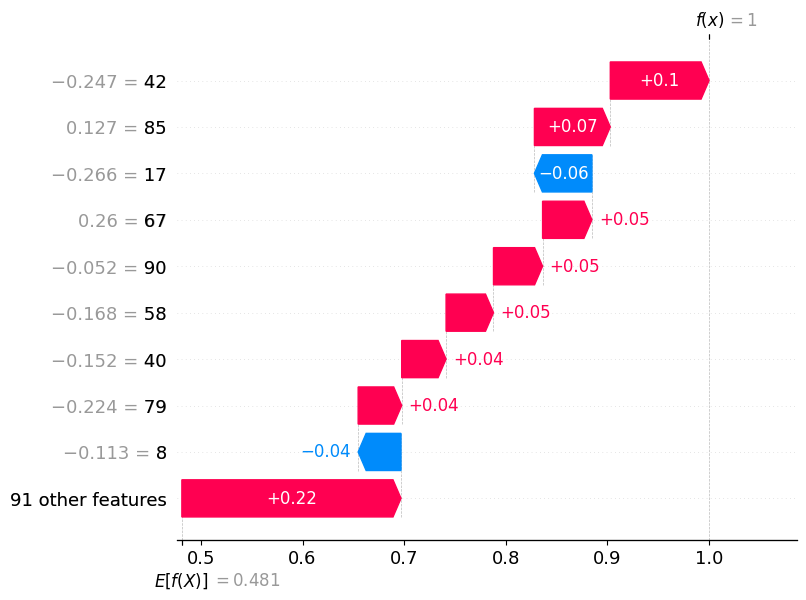

In [22]:
# generate the SHAP waterfall plot for the selected index above
shap.waterfall_plot(
    shap.Explanation(values=shap_values[i], 
                     base_values=shap_explainer.expected_value,
                     data=X_test.values[i],  
                     feature_names=[str(col) for col in X_test.columns.values.tolist()]
                     ))

In [23]:
# generate the SHAP force plot for the selected index above
shap.initjs()
shap.force_plot(shap_explainer.expected_value, shap_values[i], X_test.iloc[[i]], feature_names=X_test.columns.values.tolist())

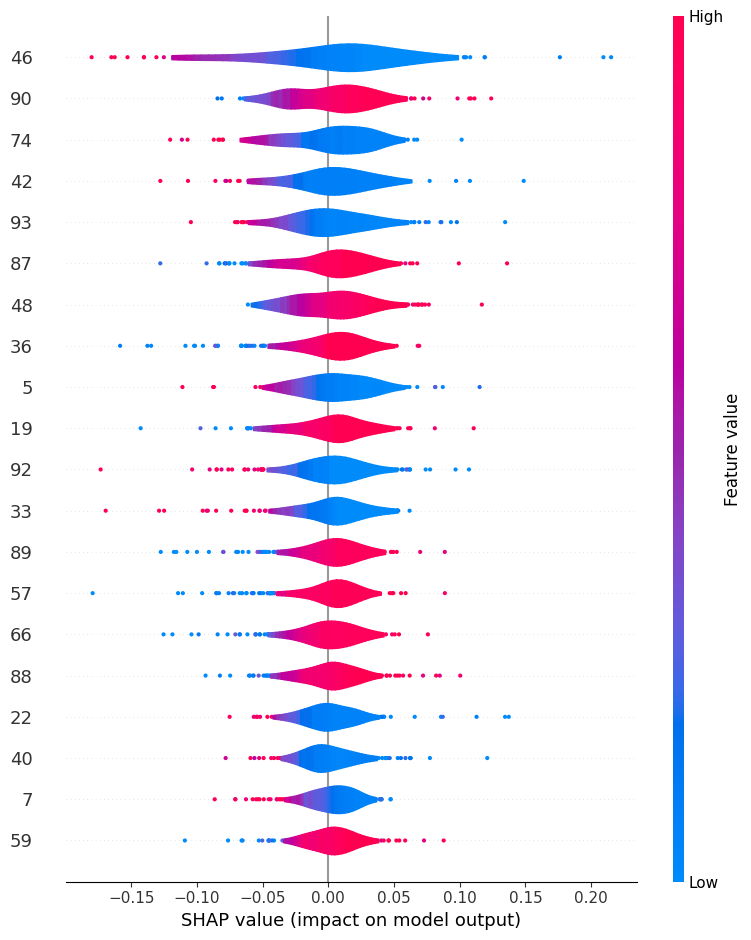

In [24]:
# generate the SHAP summary plot
shap_reshaped= np.reshape(shap_values, (-1, 100))
shap_df = pd.DataFrame(data=shap_reshaped,columns=X_train.columns.values.tolist())
shap.summary_plot(shap_reshaped, X_test, plot_type="violin")